In [1]:
from plot_lib import plot_data,plot_model,set_default

In [2]:
set_default()

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy

#function to count number of parameters
def get_n_params(model):
  np = 0
  for p in list(model.parameters()):
    np+=p.nelement()
  return np
    


In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [10]:
###torchvision.transforms.ToTensor[SOURCE]
###Convert a PIL Image or numpy.ndarray to tensor. This transform does not support torchscript.

###onverts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0] if the PIL Image belongs to one of the modes (L, LA, P, I, F, RGB, YCbCr, RGBA, CMYK, 1) or if the numpy.ndarray has dtype = np.uint8

###In the other cases, tensors are returned without scaling.

##Normalize = mean/standard deviation

In [54]:
 input_size = 28*28     #images are 28*28 pixels
 output_size = 10        #there are 10 classes

 train_loader = torch.utils.data.DataLoader(
     datasets.MNIST("../data", train =True, download = True,
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
                    ])),
                    batch_size = 64 , shuffle = True)
 test_loader = torch.utils.data.DataLoader(
     datasets.MNIST("../data", train =False, 
                    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,),(0.3081,))
                    ])),
                    batch_size = 1000 , shuffle = True)


In [55]:
#@title Default title text
#numpy.squeeze(a, axis=None)
#Remove axes of length one from a.

#Parameters:
#aarray_like
#Input data.
x = numpy.array([[[0], [1], [2]]])
x.shape
(1, 3, 1)
numpy.squeeze(x).shape
(3,)
numpy.squeeze(x, axis=0).shape
(3, 1)

(3, 1)

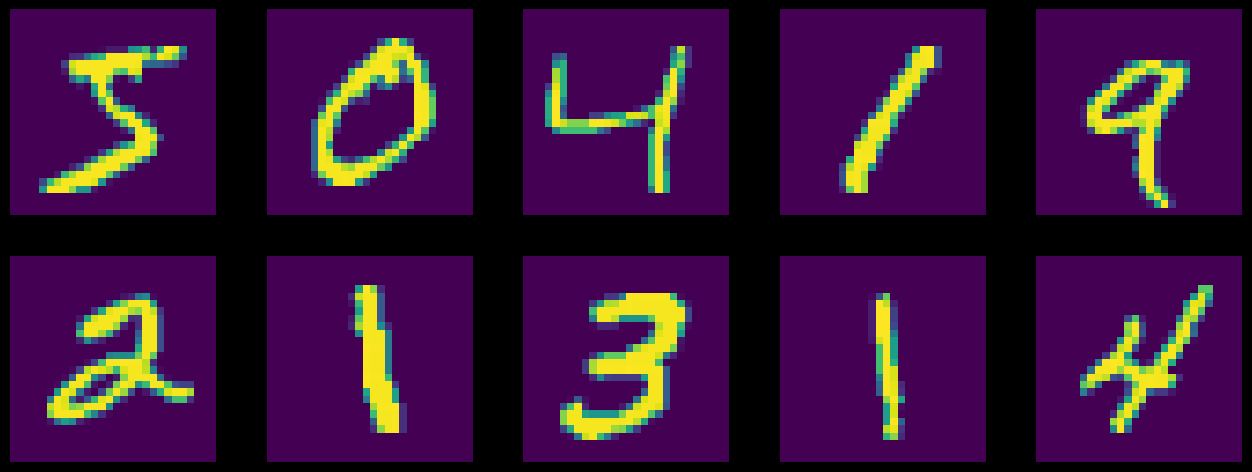

In [56]:
plt.figure(figsize = (16,6))
for i in range(10):
  plt.subplot(2,5,i+1)
  image,_ = train_loader.dataset.__getitem__(i)
  plt.imshow(image.squeeze().numpy())
  plt.axis('off');

In [96]:
class FC2Layer(nn.Module):
  def __init__(self,input_size, n_hidden, output_size):
   super(FC2Layer , self).__init__()
   self.input_size = input_size
   self.network = nn.Sequential(
        nn.Linear(input_size , n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden , n_hidden),
        nn.ReLU(),
        nn.Linear(n_hidden , output_size),
        nn.LogSoftmax(dim = 1)
    )

  def forward(self,x):
    x = x.view(-1 , self.input_size)  # it put it in a long vector because it does not know how to deal with sth that is not a vector
  
    return self.network(x)

class CNN(nn.Module):
  def __init__(self , input_size , n_feature , output_size):
    super(CNN, self).__init__()
    self.n_feature = n_feature
    self.conv1 = nn.Conv2d(in_channels=1 , out_channels= n_features , kernel_size=5)
    self.conv2 = nn.Conv2d(n_feature , n_feature, kernel_size=5)
    self.fc1 = nn.Linear(n_features*4*4 , 50)
    self.fc2 = nn.Linear(50,10)

  def forward(self, x , vector = False):
    x= self.conv1(x)
    x= F.relu(x)
    x= F.max_pool2d(x, kernel_size = 2)
    x = self.conv2(x)
    x = F.relu(x)
    x = F.max_pool2d(x , kernel_size = 2)
    x = x.view(-1 , self.n_feature*4*4)
    x = self.fc1(x)
    x = F.relu(x)
    self.fc2(x)
    x = F.log_softmax(x , dim = 1)
    return x




In [97]:
##TORCH.ARANGE
##torch.arange(start=0, end, step=1, *, out=None, dtype=None, layout=torch.strided, device=None, requires_grad=False) → Tensor
#Returns a 1-D tensor of size 
#⌈
#end−start/step


##Note that non-integer step is subject to floating point rounding errors when comparing against end; to avoid inconsistency, we advise adding a small epsilon to end in such cases.

#start (Number) – the starting value for the set of points. Default: 0.

#end (Number) – the ending value for the set of points

#step (Number) – the gap between each pair of adjacent points. Default: 1.
### torch.arange(5)
###tensor([ 0,  1,  2,  3,  4])
### torch.arange(1, 4)
###tensor([ 1,  2,  3])
### torch.arange(1, 2.5, 0.5)
##ensor([ 1.0000,  1.5000,  2.0000])

In [98]:
#TORCH.TENSOR.LONG
#Tensor.long(memory_format=torch.preserve_format) → Tensor
#self.long() is equivalent to self.to(torch.int64). See to().

#Parameters:
#memory_format (torch.memory_format, optional) – the desired memory format of returned Tensor. Default: torch.preserve_format.

In [99]:
#TORCH.OPTIM.OPTIMIZER.ZERO_GRAD
#Optimizer.zero_grad(set_to_none=False)[source]
#Sets the gradients of all optimized torch.Tensor s to zero.

In [100]:
#CLASStorch.nn.NLLLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean')[SOURCE]
##The negative log likelihood loss. It is useful to train a classification problem with C classes.

In [101]:
accuracy_list = []

def train(epoch , model , perm = torch.arange(0,784).long()):
  model.train()
  for bach_idx  , (data , target ) in enumerate(train_loader):
    #senf to device
    data, target = data.to(device) , target.to(device)

    #promote pixels
    data = data.view(-1 , 28*28)
    data = data[: , perm]
    data = data.view(-1 , 1 , 28 , 28)

    optimizer.zero_grad()
    output = model(data)
    loss = F.nll_loss(output , target)
    loss.backward()
    optimizer.step()
    if bach_idx % 100 == 0 :
      print('Train Epoch: {} [{}/{} ({:.0f}%))\tLoss:{:.6f}'.format(
          epoch , bach_idx * len(data) , len(train_loader.dataset),
          100. * bach_idx / len(train_loader) , loss.item()))
      
def test(model , perm = torch.arange(0,784).long()):
  model.eval()
  test_loss = 0
  correct = 0
  for data,target in test_loader:
    #send to drive
    data,target = data.to(device) , target.to(device)

    #permute pixxels
    data = data.view(-1 , 28 * 28)
    data = data[:,perm]
    data = data.view(-1 , 1 ,28, 28 )
    output = model(data)
    test_loss += F.nll_loss(output , target , reduction= 'sum').item() #sum up bach loss
    pred = output.data.max(1 , keepdim = True)[1] #get the index of the max log probablity
    correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

  test_loss /= len(test_loader.dataset)
  accuracy = 100 * correct / len(test_loader.dataset)
  accuracy_list.append(accuracy)
  print ('\nTest set : Average loss: {:.4f}, Accuracy: {} / {} ({:.0f}%)\n'.format(
      test_loss , correct , len(test_loader.dataset),
      accuracy
  ))


      

In [102]:
print(torch.__version__)

1.13.1+cu116


In [103]:
n_hidden = 8 #number of hidden units
output_size = 10
model_fnn = FC2Layer(input_size , n_hidden , output_size)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters() , lr = 0.01 , momentum = 0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

for epoch in range (0,1):
  train(epoch , model_fnn)
  test(model_fnn)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%))	Loss:2.313622
Train Epoch: 0 [6400/60000 (11%))	Loss:1.956302
Train Epoch: 0 [12800/60000 (21%))	Loss:1.374655
Train Epoch: 0 [19200/60000 (32%))	Loss:0.650677
Train Epoch: 0 [25600/60000 (43%))	Loss:0.645593
Train Epoch: 0 [32000/60000 (53%))	Loss:0.647072
Train Epoch: 0 [38400/60000 (64%))	Loss:0.621418
Train Epoch: 0 [44800/60000 (75%))	Loss:0.377073
Train Epoch: 0 [51200/60000 (85%))	Loss:0.387177
Train Epoch: 0 [57600/60000 (96%))	Loss:0.327966

Test set : Average loss: 0.3910, Accuracy: 8849 / 10000 (88%)



In [104]:
n_features = 6 

model_cnn = CNN(input_size , n_features , output_size)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters() , lr = 0.01 , momentum = 0.5)
print('number of parameters:{}'.format(get_n_params(model_cnn)))

for epoch in range (0,1):
  train(epoch , model_cnn)
  test(model_cnn)

number of parameters:6422
Train Epoch: 0 [0/60000 (0%))	Loss:3.925295
Train Epoch: 0 [6400/60000 (11%))	Loss:1.736592
Train Epoch: 0 [12800/60000 (21%))	Loss:1.097207
Train Epoch: 0 [19200/60000 (32%))	Loss:1.025326
Train Epoch: 0 [25600/60000 (43%))	Loss:0.968549
Train Epoch: 0 [32000/60000 (53%))	Loss:0.636841
Train Epoch: 0 [38400/60000 (64%))	Loss:0.629455
Train Epoch: 0 [44800/60000 (75%))	Loss:0.938219
Train Epoch: 0 [51200/60000 (85%))	Loss:0.642865
Train Epoch: 0 [57600/60000 (96%))	Loss:0.529332

Test set : Average loss: 0.2057, Accuracy: 9423 / 10000 (94%)

